# Baseline model for batch monitoring example

In [91]:
import requests
import datetime
import pandas as pd

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric, ColumnQuantileMetric, DatasetCorrelationsMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [92]:
files = [('green_tripdata_2023-02.parquet', './data'), ('green_tripdata_2023-03.parquet', './data')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2023-03.parquet: 100%|██████████| 1730999/1730999 [00:04<00:00, 411886.15it/s, save to ./data/green_tripdata_2023-03.parquet]


In [93]:
feb_data = pd.read_parquet('data/green_tripdata_2023-02.parquet')
march_data = pd.read_parquet('data/green_tripdata_2023-03.parquet') #will be used for monitoring in later process

### Q1.Prepare Dataset

Download the March 2023 Green Taxi data. We will use this data to simulate a production usage of a taxi trip duration prediction service.

What is the shape of the downloaded data? How many rows are there?

In [94]:
march_data.shape

(72044, 20)

In [66]:
feb_data.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,64809.000000,64809,64809,59988.000000,64809.000000,64809.000000,59988.000000,64809.000000,64809.000000,64809.000000,64809.000000,64809.000000,64809.000000,0.0,64809.000000,64809.000000,59988.000000,59983.000000,59988.000000
mean,1.867920,2023-02-14 19:27:48.982888448,2023-02-14 19:45:33.676680704,1.136527,99.988273,139.065809,1.294792,13.696354,16.646276,0.844270,0.571364,2.153087,0.182798,NaN,0.952858,21.884576,1.369207,1.028558,0.733793
min,1.000000,2008-12-31 23:02:29,2009-01-01 16:41:01,1.000000,1.000000,1.000000,0.000000,0.000000,-113.490000,-2.500000,-0.500000,-0.900000,-6.550000,NaN,-1.000000,-94.840000,1.000000,1.000000,-2.750000
25%,2.000000,2023-02-07 22:34:54,2023-02-07 23:01:51,1.000000,74.000000,74.000000,1.000000,1.130000,9.300000,0.000000,0.500000,0.000000,0.000000,NaN,1.000000,12.960000,1.000000,1.000000,0.000000
50%,2.000000,2023-02-14 19:24:38,2023-02-14 19:40:34,1.000000,75.000000,138.000000,1.000000,1.890000,13.500000,0.000000,0.500000,1.720000,0.000000,NaN,1.000000,18.000000,1.000000,1.000000,0.000000
75%,2.000000,2023-02-21 21:36:21,2023-02-21 21:52:19,1.000000,129.000000,219.000000,1.000000,3.350000,19.800000,1.000000,0.500000,3.350000,0.000000,NaN,1.000000,26.320000,2.000000,1.000000,2.750000
max,2.000000,2023-03-01 00:01:06,2023-03-01 16:51:02,99.000000,265.000000,265.000000,9.000000,178919.980000,440.000000,12.700000,4.250000,80.000000,45.350000,NaN,1.000000,441.000000,4.000000,2.000000,2.750000
std,0.338581,NaN,NaN,1.132523,61.711800,76.378947,0.944409,931.311966,12.650412,1.280076,0.386753,2.846365,1.161675,NaN,0.198828,14.721413,0.510232,0.166562,1.216754


In [67]:
feb_data.shape

(64809, 20)

In [95]:
# create target
feb_data["duration_min"] = feb_data.lpep_dropoff_datetime - feb_data.lpep_pickup_datetime
feb_data.duration_min = feb_data.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [96]:
# filter out outliers
feb_data = feb_data[(feb_data.duration_min >= 0) & (feb_data.duration_min <= 60)]
feb_data = feb_data[(feb_data.passenger_count > 0) & (feb_data.passenger_count <= 8)]

<Axes: >

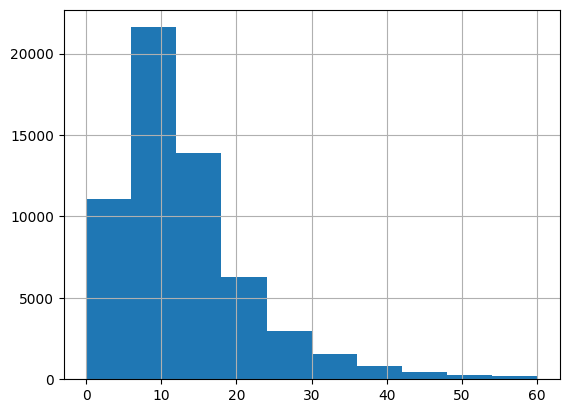

In [97]:
feb_data.duration_min.hist()

In [98]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [72]:
feb_data.shape

(59075, 21)

In [99]:
train_data = feb_data[:30000]
val_data = feb_data[30000:]

In [100]:
model = LinearRegression()

In [101]:
model.fit(train_data[num_features + cat_features], train_data[target])

LinearRegression()

In [102]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds

In [103]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [104]:
print(mean_absolute_error(train_data.duration_min, train_data.prediction))
print(mean_absolute_error(val_data.duration_min, val_data.prediction))

3.338987322004025
3.2892482305335604


# Dump model and reference data

In [105]:
with open('models/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

In [106]:
val_data.to_parquet('data/reference.parquet')

# Evidently Report

In [107]:
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [108]:
report = Report(metrics=[
    ColumnDriftMetric(column_name='prediction'),
    DatasetDriftMetric(),
    DatasetMissingValuesMetric(),
    ColumnQuantileMetric(column_name='fare_amount', quantile=0.5),
    DatasetCorrelationsMetric()
]
)

In [109]:
report.run(reference_data=train_data, current_data=val_data, column_mapping=column_mapping)

In [26]:
report.show(mode='inline') #Takes so much time

In [110]:
result = report.as_dict()

In [85]:
result

{'metrics': [{'metric': 'ColumnDriftMetric',
   'result': {'column_name': 'prediction',
    'column_type': 'num',
    'stattest_name': 'Wasserstein distance (normed)',
    'stattest_threshold': 0.1,
    'drift_score': 0.020510513288376598,
    'drift_detected': False,
    'current': {'small_distribution': {'x': [-20.661986156302476,
       7.739831101421789,
       36.14164835914605,
       64.54346561687032,
       92.94528287459458,
       121.34710013231884,
       149.74891739004312,
       178.15073464776737,
       206.55255190549164,
       234.95436916321592,
       263.35618642094016],
      'y': [0.004330436333594106,
       0.03037481391374188,
       0.0004662242696962334,
       2.421944258162252e-05,
       7.2658327744867564e-06,
       2.4219442581622507e-06,
       1.2109721290811266e-06,
       1.2109721290811254e-06,
       0.0,
       1.2109721290811266e-06]}},
    'reference': {'small_distribution': {'x': [-36.624682126802234,
       -9.286984577975755,
       18.0

In [111]:
#prediction drift
result['metrics'][0]['result']['drift_score']

0.020510513288376598

In [112]:
#number of drifted columns
result['metrics'][1]['result']['number_of_drifted_columns']

0

In [113]:
#share of missing values
result['metrics'][2]['result']['current']['share_of_missing_values']

0.04545767216446494

In [114]:
#Defined quantile value for fare_amount column
result['metrics'][3]['result']['current']['value']

12.8

In [131]:
result['metrics'][4]['result']['current']['stats']['spearman']['abs_max_features_correlation']

0.9455634910317661

In [90]:
result['metrics'][4]['result']['current']['mean_abs_error']

3.2892482305335604